In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [7]:
BASE_DIR = "/home/human/ilems/mt11-python-cartographie/projet/map/data/"
ROUTE_SHP_DIR = "ROUTE500_3-0__SHP_LAMB93_FXX_2021-11-03/ROUTE500/1_DONNEES_LIVRAISON_2022-01-00175/R500_3-0_SHP_LAMB93_FXX-ED211/"

features_path_dict = {"frontieres": "ADMINISTRATIF/LIMITE_ADMINISTRATIVE.shp",
                      "aerodromes": "RESEAU_ROUTIER/AERODROME.shp",
                      "fer": "RESEAU_FERRE/TRONCON_VOIE_FERREE.shp",
                    #   "route": "RESEAU_ROUTIER/TRONCON_ROUTE.shp",
                      "cote": "HABILLAGE/COTE_FRONTIERE.shp",
                      "eau": "HABILLAGE/TRONCON_HYDROGRAPHIQUE.shp"}

In [8]:
features_dict = {}
for key , path in features_path_dict.items():
    features_dict[key] = gpd.read_file(BASE_DIR + ROUTE_SHP_DIR + path)

# Utils

In [9]:
# parameters for Lambert93 projection
[lon0, lat0, lat1, lat2] = [np.radians(x) for x in [3, 46.5, 44, 49]]
x0, y0 = 700000, 6600000
r = 6371000

# Lambert conformal conic projection (from spherical coordinates)
def sph2lcc(lon, lat):
    lon, lat = np.radians(lon), np.radians(lat)
    n = np.sin(lat1)
    if lat1 != lat2:
        n = np.log(np.cos(lat1) / np.cos(lat2))
        n /= np.log(np.tan(np.pi / 4 + lat2 / 2) / np.tan(np.pi / 4 + lat1 / 2))
    F = r * np.cos(lat1) * np.exp(n * np.log(np.tan(np.pi / 4 + lat1 / 2))) / n
    rho = F / np.exp(n * np.log(np.tan(np.pi / 4 + lat / 2)))
    rho0 = F / np.exp(n * np.log(np.tan(np.pi / 4 + lat0 / 2)))
    x = x0 + rho * np.sin(n * (lon - lon0))
    y = y0 + rho0 - rho * np.cos(n * (lon - lon0))
    return (x, y)

# Carte des aéroports et aérodromes de France

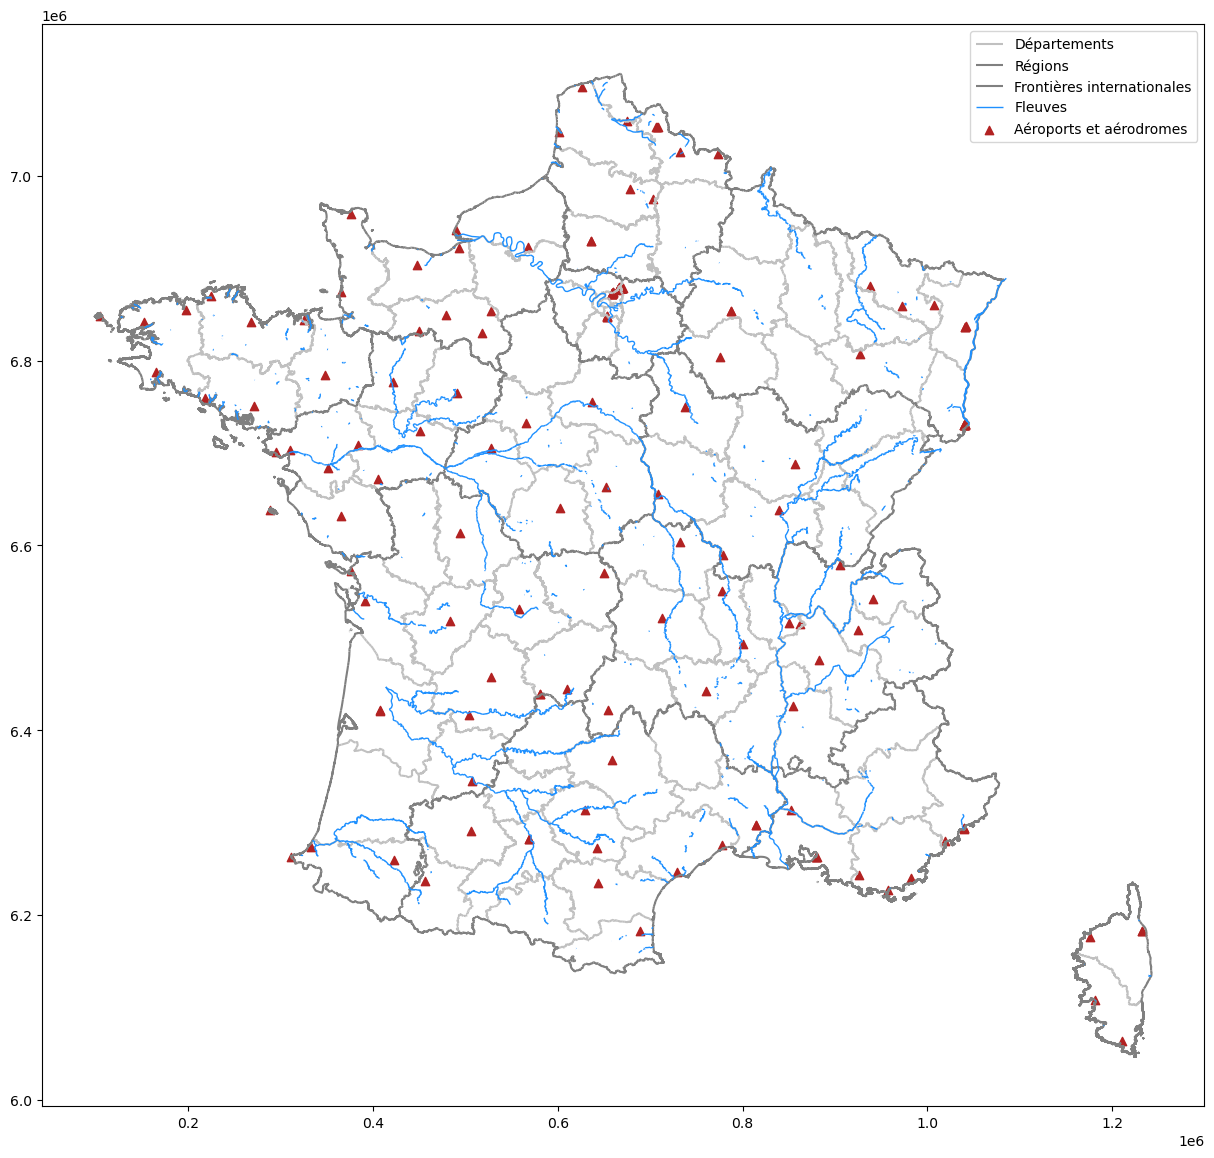

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))

features_dict["frontieres"].query("NATURE  == 'Limite de département'").plot(ax=ax, color="silver", label='Départements')
features_dict["frontieres"].query("NATURE  == 'Limite de région'").plot(ax=ax, color="gray", label='Régions')
features_dict["frontieres"].query("NATURE  in ['Frontière internationale', 'Limite côtière']").plot(ax=ax, color="gray", label='Frontières internationales')
features_dict["eau"].query( "LARGEUR == 'Plus de 50 mètres'").plot(ax=ax, color="dodgerblue", linewidth=1, label='Fleuves')
features_dict['aerodromes'].query("TOPONYME != None").plot(ax=ax, color="firebrick", marker="^", linewidth=1, label='Aéroports et aérodromes')

ax.legend()

# Cartes des récepteurs

#### Position des stations de réception

In [11]:
gps_dict = {"1": (2.343489415284081,48.85313179527069),
            "2": (2.218672000042794,48.71190699988616),
            "3": (2.171222222222222,48.70938888888889),
            "4": (2.367996649928126,48.72772029632976),
            "5": (2.196247797054214,48.78066589494499),
            "6": (2.112332288629579,48.7502920511761)}

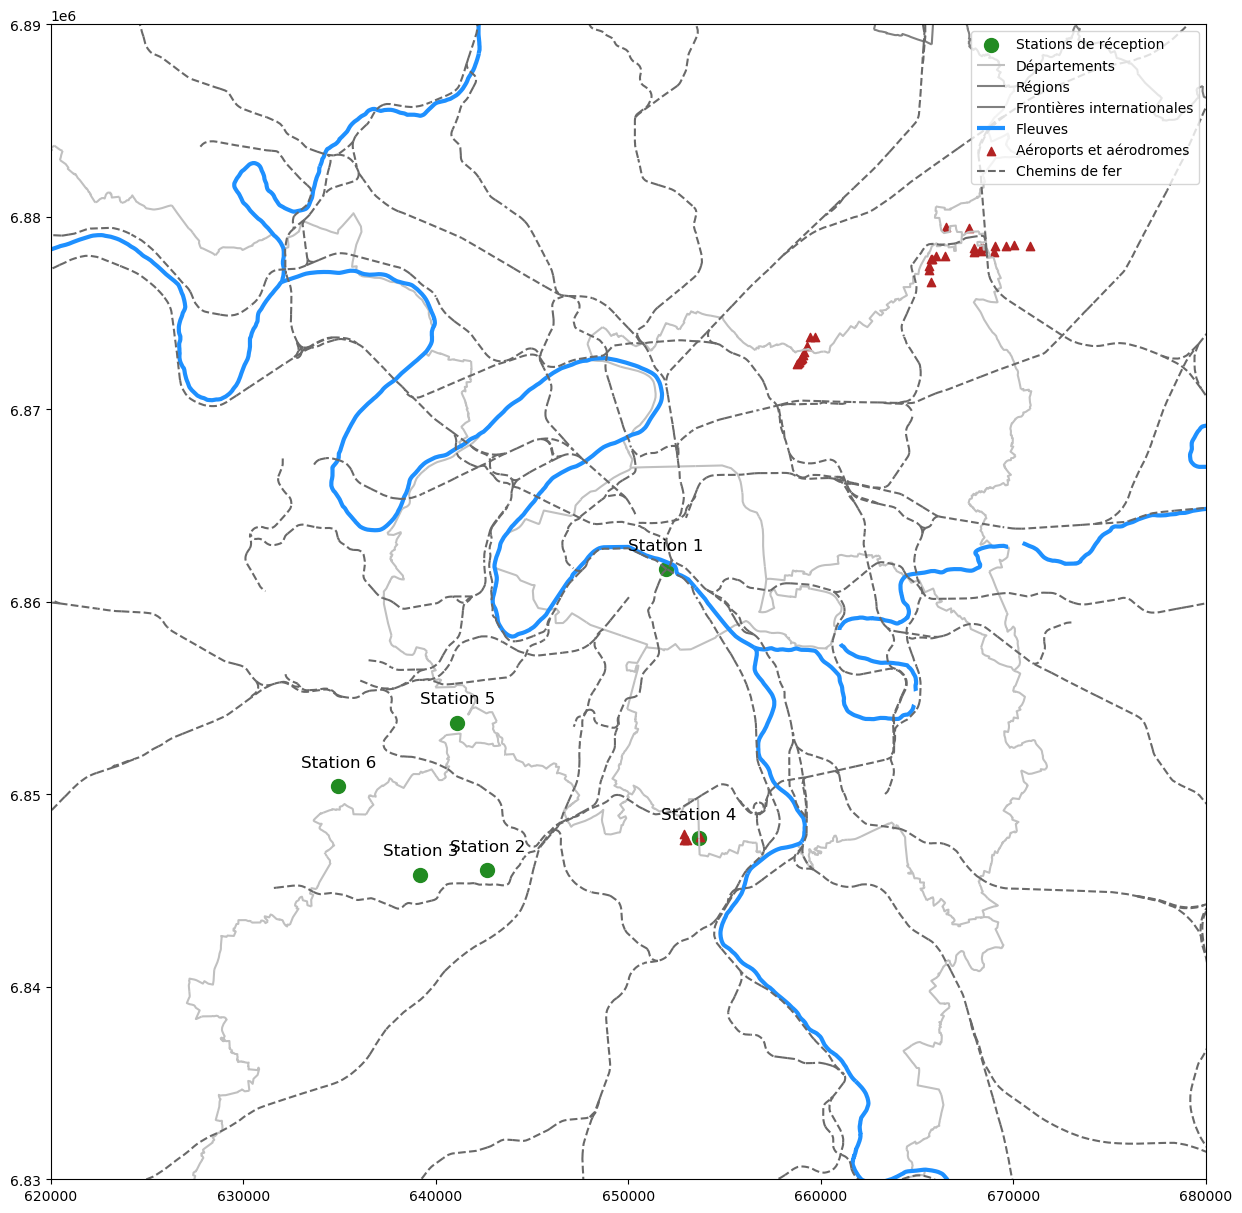

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))

for i, (id_recv, gps_pos) in enumerate(gps_dict.items()):
    x, y = sph2lcc(*gps_pos)
    if i == 0:
        ax.scatter(x, y, color="forestgreen", marker="o", s=100, alpha=1, label='Stations de réception')
    else:
        ax.scatter(x, y, color="forestgreen", marker="o", s=100, alpha=1)
    ax.text(x, y+1000, s="Station {}".format(id_recv), fontsize=12, horizontalalignment='center')

features_dict["frontieres"].query("NATURE  == 'Limite de département'").plot(ax=ax, color="silver", label='Départements')
features_dict["frontieres"].query("NATURE  == 'Limite de région'").plot(ax=ax, color="gray", label='Régions')
features_dict["frontieres"].query("NATURE  in ['Frontière internationale', 'Limite côtière']").plot(ax=ax, color="gray", label='Frontières internationales')
features_dict["eau"].query( "LARGEUR == 'Plus de 50 mètres'").plot(ax=ax, color="dodgerblue", linewidth=3, label='Fleuves')
features_dict['aerodromes'].query("TOPONYME != None").plot(ax=ax, color="firebrick", marker="^", linewidth=1, label='Aéroports et aérodromes')
# features_dict["route"].query("VOCATION == 'Type autoroutier'").plot(ax=ax, color="black", label='Autoroutes')
features_dict["fer"].plot(ax=ax, color='dimgray', linestyle='--', label='Chemins de fer')

ax.set_xlim((0.62e6, 0.68e6))
ax.set_ylim((6.83e6, 6.89e6))

ax.legend()

# Cartes des traces ADS-B

In [13]:
data_adsb = pd.read_pickle("data/full_dataset_df.pkl").sort_values(by="timestamp")

#### Messages par station

In [14]:
data_adsb['receiver'].value_counts()

Arthur     800739
Tristan    181300
Eser       172830
Vianney    157217
Laure       94095
Alexis      56965
Name: receiver, dtype: int64

#### Controle des timestamps

In [15]:
print(data_adsb.groupby('receiver')['timestamp'].min())
print(data_adsb.groupby('receiver')['timestamp'].max())

receiver
Alexis    2022-10-13 12:30:22.466972+00:00
Arthur    2022-10-13 12:30:51.510007+00:00
Eser      2022-10-13 09:32:41.711780+00:00
Laure     2022-10-13 12:29:41.983086+00:00
Tristan   2022-10-13 12:24:38.412079+00:00
Vianney   2022-10-13 12:34:38.777211+00:00
Name: timestamp, dtype: datetime64[ns, UTC]
receiver
Alexis    2022-10-13 13:31:18.794698+00:00
Arthur    2022-10-13 13:20:23.740845+00:00
Eser      2022-10-13 13:44:47.431597+00:00
Laure     2022-10-13 13:29:42.234028+00:00
Tristan   2022-10-13 13:30:27.791357+00:00
Vianney   2022-10-13 13:38:33.420982+00:00
Name: timestamp, dtype: datetime64[ns, UTC]


#### Création d'un jeu de données propre

In [16]:
data_adsb_clean = data_adsb[data_adsb.receiver != 'Eser']
pos = data_adsb_clean.dropna(subset=['latitude', 'longitude'])

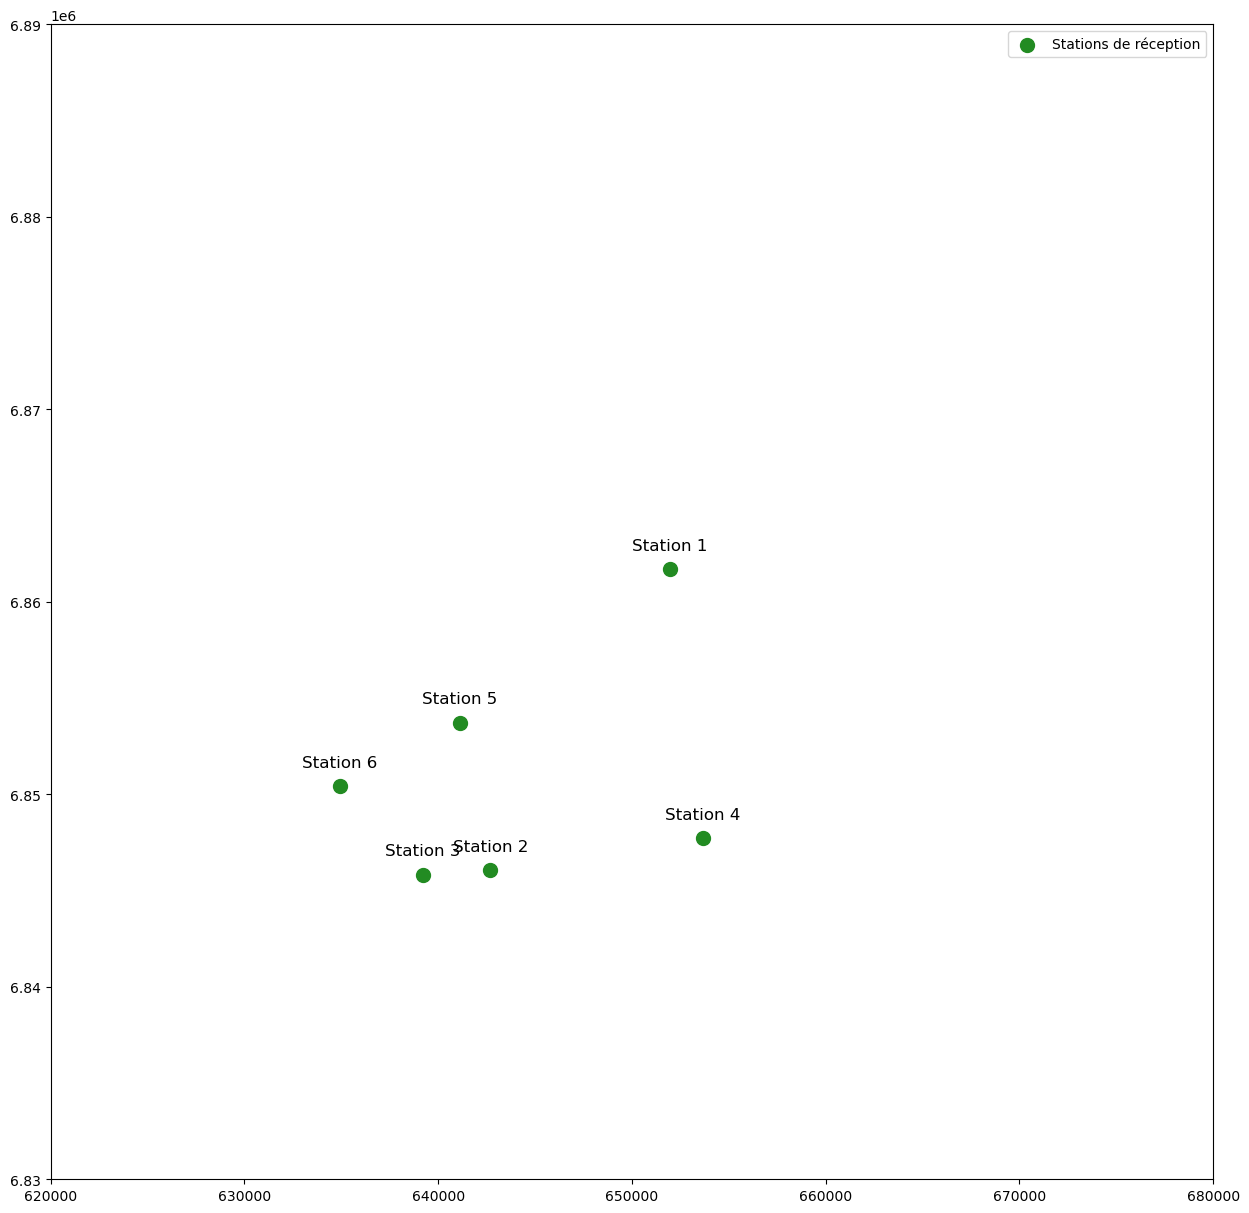

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))

for i, (id_recv, gps_pos) in enumerate(gps_dict.items()):
    x, y = sph2lcc(*gps_pos)
    if i == 0:
        ax.scatter(x, y, color="forestgreen", marker="o", s=100, alpha=1, label='Stations de réception')
    else:
        ax.scatter(x, y, color="forestgreen", marker="o", s=100, alpha=1)
    ax.text(x, y+1000, s="Station {}".format(id_recv), fontsize=12, horizontalalignment='center')

ax.set_xlim((0.62e6, 0.68e6))
ax.set_ylim((6.83e6, 6.89e6))

ax.legend()

In [18]:
pos

,timestamp,icao24,squawk,rawmsg,selected_fms,selected_mcp,barometric_setting,altitude,IAS,heading,...,TAS,track,track_rate,latitude,longitude,onground,vertical_rate,geoaltitude,callsign,receiver
1,2022-10-13 12:24:39.269392+00:00,3b77e5,NaN,8d3b77e55829906b4c76ed973e3d,NaN,NaN,NaN,7225.0,NaN,NaN,...,NaN,NaN,NaN,48.62869,2.14409,False,NaN,NaN,CTM0008,Tristan
3,2022-10-13 12:24:39.895545+00:00,346111,NaN,8d34611158c907d4228444d3db6e,NaN,NaN,NaN,39000.0,NaN,NaN,...,NaN,NaN,NaN,48.55217,2.44735,False,NaN,NaN,VLG613B,Tristan
6,2022-10-13 12:24:39.928886+00:00,7816c6,NaN,8d7816c658392431de7c47db2718,NaN,NaN,NaN,10250.0,NaN,NaN,...,NaN,NaN,NaN,49.11070,2.29954,False,NaN,NaN,CSN348,Tristan
7,2022-10-13 12:24:40.650835+00:00,4d226a,NaN,8d4d226a60c380972e990f2adbe0,NaN,NaN,NaN,38000.0,NaN,NaN,...,NaN,NaN,NaN,48.88582,2.75947,False,NaN,NaN,RYR79AV,Tristan
2,2022-10-13 12:24:40.766893+00:00,4008ad,NaN,8d4008ad58bdf09888660816a9bc,NaN,NaN,NaN,36975.0,NaN,NaN,...,NaN,NaN,NaN,48.89374,1.83951,False,NaN,NaN,BAW574,Tristan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2022-10-13 13:38:32.593062+00:00,4cac64,NaN,8d4cac64582970a4fc7ed9853d2a,NaN,NaN,NaN,7175.0,NaN,NaN,...,NaN,NaN,NaN,48.96671,2.28692,False,NaN,NaN,ABR471,Vianney
1213,2022-10-13 13:38:32.808172+00:00,06a1e6,NaN,8d06a1e658a10085366a0794b58d,NaN,NaN,NaN,31000.0,NaN,NaN,...,NaN,NaN,NaN,48.78053,1.91155,False,NaN,NaN,QTR8157,Vianney
227,2022-10-13 13:38:32.965429+00:00,4951d3,NaN,8d4951d358c3842ff24ef7e41687,NaN,NaN,NaN,38000.0,NaN,NaN,...,NaN,NaN,NaN,49.09925,1.46111,False,NaN,NaN,TAP758,Vianney
1361,2022-10-13 13:38:33.206526+00:00,3c4d4a,NaN,8d3c4d4a58a5840d9a92a439f724,NaN,NaN,NaN,32000.0,NaN,NaN,...,NaN,NaN,NaN,48.89461,2.71333,False,NaN,NaN,LGL624,Vianney
